# Indirect social influence helps shaping the diffusion of innovations

## Analysis of human decisions

### Libraries import

In [7]:
import numpy as np
import os
import pandas as pd
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

### Prediction of human decision using Random Forest clasifier

#### Dependent variable: color chosen (binary). 1: innovation color chosen, 0: no innovation color chosen
#### Independent variables: "Innovation as initial color" (binary), "Innovation as majority color seen" (binary), "Percentage of first neighbors with the innovation color" (float in [0,1]), "Percentage of n-distance neighbors with the innovation color" (float in [0,1])

In [8]:
# random seed
seed=1123

# Load the file as a dataframe
data = pd.read_csv("Unified_data_edited_innov3_classification.csv")

#Filter the dataset for bot=0 and Setup different than "instructions"
data = data[(data['bot'] == 0) & (data['Setup'] != 'instructions')]

misLabels=["Setting I","Setting II","Setting III","Setting IV"]
misFeatureLabels=["Innovation as initial color", "Innovation as majority color seen", "Percentage of first neighbors with the innovation color", "Percentage of n-distance neighbors with the innovation color"]

# Keep just the columns: innovationAsInitialcolor, InnovationAsMajorityColorSeen, perc_color_neigbors, perc_color_friends, Adopted_color
data = data[['InnovationAsInitialcolor', 'InnovationAsMajorityColorSeen', 'perc_color_neigbors', 'perc_color_friends', 'Adopted_color']]


# Create a Random Forest Classifier to predict the "Adopted_color" column using the other columns as features
# Use two nested cross validation loops, one to tune the hyperparameters and the other to evaluate the model

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest Classifier
rf = RandomForestClassifier()


# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(data.drop('Adopted_color', axis=1), data['Adopted_color'])

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best hyperparameters to create the final model
final_model = RandomForestClassifier(**best_params)

# Perform nested cross validation to evaluate the model
nested_scores = cross_val_score(final_model, data.drop('Adopted_color', axis=1), data['Adopted_color'], cv=5)

# Print the average accuracy of the nested cross validation
print("Nested Cross Validation Accuracy:", np.mean(nested_scores))


# Fit the model
final_model.fit(data.drop('Adopted_color', axis=1), data['Adopted_color'])

#Save the model
joblib.dump(final_model, "final_model.pkl")


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Nested Cross Validation Accuracy: 0.8444024681470028


['final_model.pkl']

#### Analysis of feature importance. All settings together (a general view)

   importance
2    0.763560
3    0.155161
1    0.057980
0    0.023299


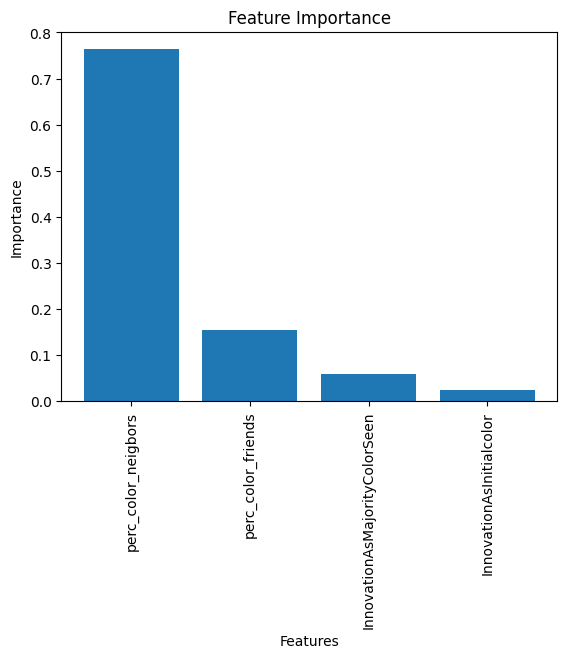

In [9]:
# Load the model
final_model = joblib.load("final_model.pkl")

# Now create a figure of the importance of each feature
# Get feature importances
importances = final_model.feature_importances_
# Get feature names
feature_names = data.drop('Adopted_color', axis=1).columns
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
# Create plot
plt.figure()
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
#plt.show()

#Save to pdf
plt.savefig("Feature_importance.pdf", format="pdf", bbox_inches="tight")

feature_importances = pd.DataFrame(final_model.feature_importances_,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

### Analysis per Experimental setting:
1) Random Forest tunning, using nested cross-validation, tune and compute accuracy and standard deviation for the accuracy
2) Feature importance per setting to establish comparison among settings (experimental treatments)

In [12]:
# Load the file as a dataframe
data = pd.read_csv("Unified_data_edited_innov3_classification.csv")

#Filter the dataset for bot=0 and Setup different than "instructions"
data = data[(data['bot'] == 0) & (data['Setup'] != 'instructions')]
#Keep just the columns: Setup, innovationAsInitialcolor, InnovationAsMajorityColorSeen, perc_color_neigbors, perc_color_friends, Adopted_color
data = data[['Setup','InnovationAsInitialcolor', 'InnovationAsMajorityColorSeen', 'perc_color_neigbors', 'perc_color_friends', 'Adopted_color']]

# Get feature names
feature_names = data.columns[1:5]

# Create a new dataframe with the columns: Setup, NCV Accuracy, sd
results_df = pd.DataFrame(columns=["Setup", "NCV Accuracy", "sd"])
# add the columns with names in feature_names
results_df = pd.concat([results_df, pd.DataFrame(columns=feature_names)], ignore_index=True)


# Define the hyperparameters to tune for the Random Forest Classifier
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#Iterate over the unique values of the "Setup" column
# For each setup, calculate the accuracy of the model using the innovationAsInitialcolor, InnovationAsMajorityColorSeen, perc_color_neigbors, perc_color_friends columns. Store it in the results_df dataframe column "NCV Accuracy
# Compute also the standard deviation of the accuracy using 5-fold cross validation. Store it in the results_df dataframe column sd

# Iterate over the unique values of the "Setup" column
for setup in data['Setup'].unique():

    # Filter the data for the current setup
    setup_data = data[data['Setup'] == setup]
    setup_data.drop('Setup', axis=1, inplace=True) #No hago la predicción con el setup
    
    X = setup_data.drop('Adopted_color', axis=1)
    y = setup_data['Adopted_color']

    rf = RandomForestClassifier()

    # Perform nested cross validation to tune the hyperparameters and evaluate the model
    grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    final_model = RandomForestClassifier(**best_params)

    # Fit the model
    final_model.fit(X, y)
    nested_scores = cross_val_score(final_model, X, y, cv=5)
    
    # Calculate the average accuracy and standard deviation
    avg_accuracy = np.mean(nested_scores)
    std_accuracy = np.std(nested_scores)

    #Compute the importance of each feature
    importances = final_model.feature_importances_
    # importances series to df with column names
    importances_df = pd.DataFrame({'0': importances}, index=feature_names).transpose()
    resultados= pd.DataFrame({'Setup': [setup], 'NCV Accuracy': [avg_accuracy], 'sd': [std_accuracy]})

    # Save the results to the results_df dataframe using pd.concat
    prev_results = pd.concat([resultados, importances_df], ignore_index=False, axis=1, names=["Setup", "NCV Accuracy", "sd"] + feature_names.tolist()) 
    # Desplaza las columnas 3 a la 7 una fila más arriba
    prev_results.iloc[:, 3:7] = prev_results.iloc[:, 3:7].shift(-1)
    #borra la última fila
    prev_results = prev_results[:-1]

    results_df = pd.concat([results_df, prev_results], ignore_index=False, axis=0, names=["Setup", "NCV Accuracy", "sd"] + feature_names.tolist())

    
#Save results_df to a csv file
results_df.to_csv("results_comparison.csv", index=False)

print(results_df)

Index(['InnovationAsInitialcolor', 'InnovationAsMajorityColorSeen',
       'perc_color_neigbors', 'perc_color_friends'],
      dtype='object')


'\n# Create a new dataframe with the columns: Setup, NCV Accuracy, sd\nresults_df = pd.DataFrame(columns=["Setup", "NCV Accuracy", "sd"])\n# add the columns with names in feature_names\nresults_df = pd.concat([results_df, pd.DataFrame(columns=feature_names)], ignore_index=True)\n\n\n# Define the hyperparameters to tune for the Random Forest Classifier\nparam_grid = {\n    \'n_estimators\': [100, 300],\n    \'max_depth\': [None, 5, 10],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4]\n}\n\n#Iterate over the unique values of the "Setup" column\n# For each setup, calculate the accuracy of the model using the innovationAsInitialcolor, InnovationAsMajorityColorSeen, perc_color_neigbors, perc_color_friends columns. Store it in the results_df dataframe column "NCV Accuracy\n# Compute also the standard deviation of the accuracy using 5-fold cross validation. Store it in the results_df dataframe column sd\n\n# Iterate over the unique values of the "Setup" column\nfo